## Homework about [ddpm](https://arxiv.org/pdf/2006.11239.pdf).  


---
To get full points it's enough to use Google Colab.


In [ ]:
!pip3 install wandb torch_ema denoising_diffusion_pytorch

## Dataset

In [ ]:
import torch

In [ ]:
import numpy as np

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from typing import Generator, Tuple, Dict, Optional, Union
from torch import Tensor
from cv2 import resize


def preprocess_image(image: "PIL.Image") -> np.ndarray:
    image = np.array(image, dtype=np.uint8)
    image = resize(image, (32, 32))
    return np.array(image, dtype=np.float32) / 127.5 - 1


def postprocess_image(image: torch.Tensor) -> torch.Tensor:
    # convert values to [0; 255]
    image = image.cpu().detach()
    image = (image + 1) * 127.5
    image = torch.clip(image, 0, 255)
    return image


class MnistDataset(Dataset):
    def __init__(self, train: bool = True):
        super().__init__()
        self.mnist = MNIST(
            'data',
            train=train,
            download=True
        )

    def __len__(self) -> int:
        return len(self.mnist)

    def __getitem__(self, index: int) -> Dict[str, Tensor]:
        image, target = self.mnist[index]
        image = preprocess_image(image)
        target = int(target)
        return {
            "images": Tensor(image)[None],
            "targets": target
        }

In [ ]:
def dict_to_device(dct: Dict[str, Tensor], device: torch.device) -> Dict[str, Tensor]:
    return {k: v.to(device) for k, v in dct.items()}


def get_train_images_generator(
    batch_size: int = 128,
    num_workers: int = 0,
    shuffle: bool = True,
    drop_last: bool = True
) -> Generator[Dict[str, Tensor], None, None]:
    dataset = MnistDataset(train=True)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        drop_last=drop_last
    )
    while True:
        yield from loader

In [ ]:
def check_generator(batch_size: int = 128):
    generator = get_train_images_generator(batch_size)
    batch_dict = next(generator)
    assert(batch_dict['images'].shape == (batch_size, 1, 32, 32), batch_dict['images'].shape)
    assert(batch_dict['targets'].shape == (batch_size,), batch_dict['targets'].shape)

check_generator(131)

## DDPM's dynamic, 3.5 pts



В `get_coeffs_primities` (1 pts) - returns dict of coefficients to sample from $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$.

Example:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha_t} = \prod_{t=1}^{T} \alpha_t$
- $\sqrt{\bar{\alpha_t}}$
- ...
- Any cofficients that help you get $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$

`extract_values_from_times` - from 1-d tensor of coefficients from times $t$ get coeffs to apply in operations with 4-d tensors

### DDPM sampling

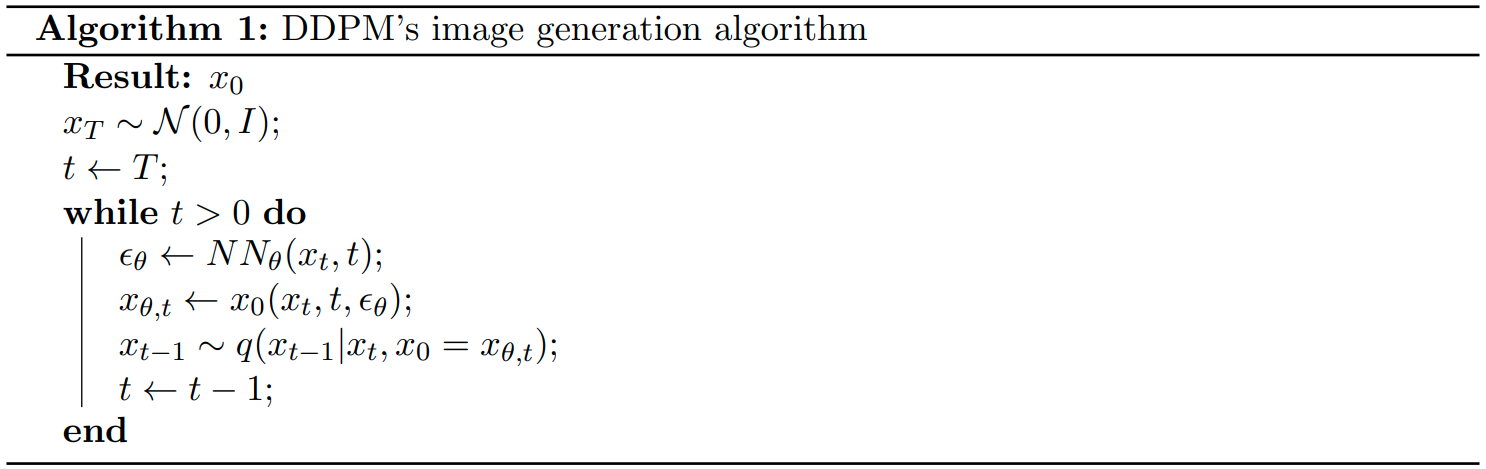

### $x_0$ parametrization vs $\epsilon$ parametrization (0.5 pts)

>  $q(x_t|x_{t+1}, x_0)$ <-> $x_t = c_{x_{t+1}} x_{t+1} + c_{x_0} x_0 + \sigma_t \epsilon$
>> So to get your scores definitely find $c_{x_{t+1}}, c_{x_0}$ 

>> How $x_0(x_t, t, \epsilon_{\theta})$ is look like? If your ddpm's neural net was trained on "x_0" parametrization, how can you get $\epsilon_{\theta}$ ?

>>> Your answer

>> What would be different in algorithm, if NN was trained on "x_0" parametrization?

>>> Your answer

In this work it's expected you will experiment with two parametrization, if you don't, scores will be halfed

In [ ]:
from torch import nn


def get_coeffs_primitives(
    T: int = 1000,
    beta_min: float = 1e-4,
    beta_max: float = 2e-2,
    betas: Optional[Tensor] = None
) -> Dict[str, Tensor]:
    """
    output: Dict[str, Tensor]
      {
        "a": b
      }
    ---
    b.shape == (T,)
    """
    return {
        "posterior_x_0_coef": posterior_x_0_coef,
        "posterior_x_t_coef": posterior_x_t_coef,
        "posterior_sigma": posterior_sigma,
    }


def extract_values_from_times(values: Tensor, times: torch.LongTensor) -> Tensor:
    values = values[times]
    return values[:, None, None, None]


`DDPMDynamic`: (1 pts)
- `__init__` - get coefficients, add them to the class as attributes, so we can access them by name without using a dictionary
- `sample_from_posterior_q(x_t: FloatTensor, x_0: FloatTensor, t: LongTensor)` - $ x_{t-1} \sim q(x_{t-1} | x_{t}, x_0) $
- `get_eps_from_x_zero(x_t: FloatTensor, x_0: FloatTensor, t: LongTensor)` - $\epsilon(x_t, x_0, t)$
- `get_x_zero(x_t: FloatTensor, eps: FloatTensor, t: LongTensor)` - $x_0(x_t, \epsilon, t)$
- `forward` - $ x_{t} \sim q(x_t | x_0) $

This module don't know about parametrization, it's usage is only for operating with $x_0, \epsilon, x_t, t$ 

In [ ]:
class DDPMDynamic(nn.Module):
    def __init__(
        self,
        T: int = 1000,
        beta_min: float = 1e-4,
        beta_max: float = 2e-2,
    ):
        super().__init__()
        self.T = T

        coeffs_primitives = get_coeffs_primitives(T, beta_min, beta_max)

        for name, tensor in coeffs_primitives.items():
            self.register_buffer(name, tensor)

    def sample_time_on_device(self, batch_size: int = 1, device: torch.device = torch.device('cpu')):
        return torch.randint(0, self.T, (batch_size,), device=device)

    def sample_from_posterior_q(
        self,
        x_t: Tensor,
        x_0: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        pass

    def get_eps_from_x_zero(
        self,
        x_t: Tensor,
        x_0: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        pass

    def get_x_zero(
        self,
        x_t: Tensor,
        eps: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        pass

    def forward(self, batch: Dict[str, Tensor]) -> Dict[str, Tensor]:
        """
            Dict:
                x_0 - clean_image
                t - time (int \in [0; T - 1])
                eps - Optional[corresponding noise]
        Returns:
            Dict:
                x_t - noised_sample
                eps - corresponding noise
        """
        pass


In [ ]:
def check_ddpm_dynamic():
    dynamic = DDPMDynamic()
    device = torch.device('cuda:0')
    dynamic.to(device)
    times = dynamic.sample_time_on_device(10, device)
    assert times.device == device, f'{times.device}, {device}'
    assert times.shape == (10,)

check_ddpm_dynamic()

In [ ]:
target_coeffs = torch.load('coeffs_dict.pth', map_location='cpu')
calc_coeffs = get_coeffs_primitives()
assert torch.allclose(calc_coeffs["posterior_x_0_coef"], target_coeffs["posterior_x_0_coef"])
assert torch.allclose(calc_coeffs["posterior_x_t_coef"], target_coeffs["posterior_x_t_coef"])

### `Sampler`/DDPM's cycle: (1 pts / 0.5 pts)
- `single_step` - you need to sample $x_{t-1} \sim p(x_{t-1}|x_t)$
- `sample` - the entire process of traversing the Markov sampling chain

Here you need to implement sampling for two ddpm's parametrizations

In [ ]:
from tqdm.auto import trange


class Sampler(nn.Module):
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic,
        parametrization: str = 'eps' # either `eps` or `x_0`
    ):
        super().__init__()
        ddpm.eval()
        self.ddpm = ddpm
        self.dynamic = dynamic
        assert parametrization in ['eps', 'x_0']
        self.parametrization = parametrization

    @torch.no_grad()
    def single_step(self, x_t, t):
        pass

    @torch.no_grad()
    def sample(
        self,
        shape: Tuple[int, int, int, int],
        device: torch.device = torch.device('cpu'),
        verbose: bool = False
    ) -> Tensor:
        pass


### DDPM's training (0.5 pts)

> In `DiffusionTrainer` you should pay attention to `calc_loss` method you need implement, it's not expected to extensively experiment with different loss weightnings, simple `.mean()` in right place is enough
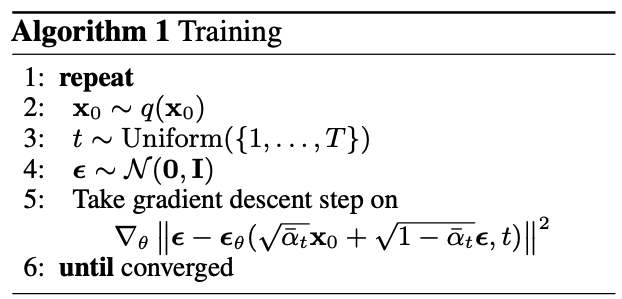

In [ ]:
from torch_ema import ExponentialMovingAverage
import wandb
import math
import torchvision


class DiffusionTrainer:
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic,
        device: torch.device = torch.device('cpu'),
        parametrization: str = 'eps',
    ):
        self.ddpm = ddpm
        self.dynamic = dynamic

        self.dynamic.to(device)
        self.ddpm.to(device)

        self.sampler = Sampler(ddpm, dynamic, parametrization=parametrization)
        self.sampler.to(device)
        self.parametrization = parametrization

        self.ema = ExponentialMovingAverage(ddpm.parameters(), decay=0.999)

        self.device = device


        self.optimizer = torch.optim.AdamW(
            self.ddpm.parameters(),
            lr=2e-4,
            weight_decay=1e-2
        )

        self.step = 0

    def switch_to_ema(self) -> None:
        self.ema.store(self.ddpm.parameters())
        self.ema.copy_to(self.ddpm.parameters())

    def switch_back_from_ema(self) -> None:
        self.ema.restore(self.ddpm.parameters())

    def calc_loss(self, x_0: torch.Tensor) -> torch.Tensor:
        return "loss"

    def log_metric(self, metric_name: str, loader_name: str, value: Union[float, torch.Tensor, wandb.Image]):
        wandb.log({f'{metric_name}/{loader_name}': value}, step=self.step)

    def optimizer_logic(self, loss: torch.Tensor) -> None:
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.ema.update(self.ddpm.parameters())

    def train(
        self,
        train_generator: Generator[Dict[str, Tensor], None, None],
        total_iters: int = 5000,
        project_name: str = 'discrete_time_ddpm',
        experiment_name: str = 'mnist_baseline'
    ) -> None:
        session = wandb.init(project=project_name, name=experiment_name)

        self.ddpm.train()

        for iter_idx in trange(1, 1 + total_iters):
            self.step = iter_idx

            batch = next(train_generator)
            batch = dict_to_device(batch, device=self.device)

            loss = self.calc_loss(x_0=batch['images'])
            self.log_metric('mse', 'train', loss)

            self.optimizer_logic(loss)

            if iter_idx % 1000 == 0:
                self.snapshot()

        self.ddpm.eval()
        self.switch_to_ema()

        session.finish()

    @torch.no_grad()
    def sample_images(
            self, batch_size: int,
            verbose: bool = False
    ) -> torch.Tensor:
        x_pred = self.sampler.sample((batch_size, 1, 32, 32), self.device, verbose)
        x_pred = postprocess_image(x_pred)
        return x_pred

    @torch.no_grad()
    def snapshot(self) -> None:
        prev_mode = self.ddpm.training

        self.ddpm.eval()
        self.switch_to_ema()

        images = self.sample_images(100).cpu()
        nrow = 10
        grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
        grid = grid.data.numpy().astype(np.uint8)
        self.log_metric('images', 'from_noise', wandb.Image(grid))

        self.switch_back_from_ema()
        self.ddpm.train(prev_mode)

In [ ]:
from denoising_diffusion_pytorch import Unet

ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 4),
    channels=1,
    flash_attn=True
)

In [ ]:
device = torch.device('cuda:0')

In [ ]:
trainer = DiffusionTrainer(
    ddpm,
    DDPMDynamic(),
    device,
    parametrization='x_0'
)

In [ ]:
generator = get_train_images_generator(128)

In [ ]:
from matplotlib import pyplot as plt
import math

@torch.inference_mode()
def sample_images(
    sampler: Sampler, batch_size: int = 100,
    device = torch.device('cpu'),
    verbose: bool = True
):
    images = sampler.sample((batch_size, 1, 32, 32), device, True)
    images = postprocess_image(images)
    images = images.cpu()
    nrow = int(math.ceil(math.sqrt(batch_size)))
    grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)
    return grid

grid = sample_images(trainer.sampler, 100, trainer.device)

plt.imshow(grid)

### Classifer-guidance sampling (2 pts)

#### Some intuition for classifier-guidance sampling (0.5 pts)

>> $\nabla_x \log p(x | y) = \nabla_x \log p(x) + \nabla_x \log p(y | x) $

>> $\nabla_{x_t} \log p_{\theta}(x_t, t) = \dfrac{-\epsilon_{\theta}(x_t, t)}{\sqrt{1 - \bar{\alpha}_t}}$

>> So in fact, when you use ddpm for $x_0, \epsilon$, etc. prediction, you step in the "score" direction, score - gradient of log probability by x

>>> Simplify terms in $x_{t-1}$ prediction by $x_t$, $\epsilon_{\theta}$ to see that "score" of the classifier is used with positive coefficent

>>> Your answer


>> So now you know that sampling can be rewritten in the form with "score", what if you use cond. score inplace of standard? You need to define - what is $\nabla_{x_t} \log p(y | x_t)$
>>> Let's just train classifier which must get $x_t$ and return logits of classes from training set. Logits then are casted to log probabilities, you calculating gradint from one selected log prob by $x_t$

>> Show how $\epsilon_{\theta, \phi}, x_{0}^{\theta, \phi}$ prediction will change with "score" from classifier $\phi$ ?
>>> Your answer

>>> In practice inplace of $\nabla_x \log p(x | y) = \nabla_x \log p(x) + \nabla_x \log p(y | x)$, people use $\nabla_x \log p(x | y) = \nabla_x \log p(x) + T \nabla_x \log p(y | x)$, where $T$ - some positive coeffs to adjust condition

In [ ]:
!git clone https://github.com/openai/guided-diffusion.git guided
%cd guided
!pip3 install -v -e .
%cd ..

In [ ]:
from guided.guided_diffusion.unet import EncoderUNetModel


class NoisyClassifier(nn.Module):
    def __init__(
        self,
    ):
        super().__init__()
        self.noisy_classifier = EncoderUNetModel(
            image_size=32,
            in_channels=1,
            model_channels=32,
            out_channels=10,
            num_res_blocks=2,
            attention_resolutions=(2, 2),
            pool='spatial'
        )
        self.noisy_classifier.out = nn.Sequential(
            nn.Linear(1472, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x_t, t):
        return self.noisy_classifier(x_t, t)

In [ ]:
noisy_classifier = NoisyClassifier()
noisy_classifier(torch.randn(10, 1, 32, 32), torch.randn(10)).shape

#### `GuidanceSampler` (1.5 pts)

* `get_eps_theta_phi(x_t: Tensor, t: torch.LongTensor, y: torch.LongTensor)` - calculate simple unconditional $\epsilon_{\theta}$, then adjust it with "score" from noisy-classifier
    * to get from model's output gradient of input in torch, you should use `torch.autograd.grad`
* `single_step`, `sample` - have the same logic as simple unconditional sampler

In [ ]:
class GuidanceSampler(nn.Module):
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic,
        noisy_classifier: nn.Module,
        gamma: float = 1, # temperature for scaling score from noisy-classifier
        parametrization: str = 'eps'
    ):
        super().__init__()
        self.ddpm = ddpm
        self.dynamic = dynamic
        self.noisy_classifier = noisy_classifier
        self.gamma = gamma
        assert parametrization in ['eps', 'x_0']
        self.parametrization = parametrization

    @torch.no_grad()
    def get_eps_theta_phi(self, x_t: Tensor, t: torch.LongTensor, y: torch.LongTensor):
        pass

    @torch.no_grad()
    def single_step(self, x_t: Tensor, t: torch.LongTensor, y: torch.LongTensor) -> Tensor:
        pass

    @torch.no_grad()
    def sample(
        self,
        shape: Tuple[int, int, int, int],
        y: torch.LongTensor,
        device: torch.device = torch.device('cpu'),
        verbose: bool = False
    ) -> Tensor:
        pass

In [ ]:
from torch.nn.functional import cross_entropy


class NoisyClassifierTrainer:
    def __init__(
        self,
        ddpm: nn.Module,
        classifier: nn.Module,
        dynamic: DDPMDynamic,
        gamma: float = 1,
        device: torch.device = torch.device('cpu'),
        parametrization: str = 'eps'
    ):
        self.classifier = classifier
        self.dynamic = dynamic

        self.dynamic.to(device)
        self.classifier.to(device)

        self.device = device

        self.optimizer = torch.optim.AdamW(
            self.classifier.parameters(),
            lr=2e-4,
            weight_decay=1e-2
        )
        for param in ddpm.parameters():
            param.requires_grad = False
        ddpm.eval()

        self.sampler = GuidanceSampler(
            ddpm, dynamic, classifier, gamma, parametrization
        )
        self.sampler.to(device)

        self.step = 0

    def calc_loss(self, x_0: torch.Tensor, y: torch.Tensor) -> Dict[str, torch.Tensor]:
        return "loss"

    def log_metric(self, metric_name: str, loader_name: str, value: Union[float, torch.Tensor, wandb.Image]):
        wandb.log({f'{metric_name}/{loader_name}': value}, step=self.step)

    def optimizer_logic(self, loss: torch.Tensor) -> None:
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(
        self,
        train_generator: Generator[Dict[str, Tensor], None, None],
        val_loader: DataLoader,
        total_iters: int = 1000,
        project_name: str = 'discrete_time_ddpm',
        experiment_name: str = 'noisy_classifier'
    ) -> None:
        session = wandb.init(project=project_name, name=experiment_name)

        self.classifier.train()

        for iter_idx in trange(1, 1 + total_iters):
            self.step = iter_idx

            batch = next(train_generator)
            batch = dict_to_device(batch, device=self.device)

            outs = self.calc_loss(x_0=batch['images'], y=batch['targets'])
            self.log_metric('CE', 'train', outs['loss'])
            self.log_metric('accuracy', 'train', outs['accuracy'])

            self.optimizer_logic(outs['loss'])

            if iter_idx % 500000 == 0:
                self.validate(val_loader)
                self.snapshot()
        self.classifier.eval()
        session.finish()

    @torch.no_grad()
    def validate(self, val_loader: DataLoader) -> None:
        prev_mode = self.classifier.training
        self.classifier.eval()
        total_acc = 0
        total_loss = 0
        total_count = 0
        for batch in val_loader:
            batch = dict_to_device(batch, self.device)
            outs = self.calc_loss(x_0=batch['images'], y=batch['targets'])
            total_acc += outs['accuracy'] * batch['images'].shape[0]
            total_loss += outs['loss'] * batch['images'].shape[0]
            total_count += batch['images'].shape[0]

        acc = total_acc / total_count
        loss = total_loss / total_count
        self.log_metric(f'accuracy', 'valid', acc)
        self.log_metric(f'CE', 'valid', loss)
        self.classifier.train(prev_mode)


    @torch.no_grad()
    def sample_images(
            self,
            y: torch.LongTensor,
            verbose: bool = False
    ) -> torch.Tensor:
        batch_size = len(y)
        x_pred = self.sampler.sample((batch_size, 1, 32, 32), y, self.device, verbose)
        x_pred = postprocess_image(x_pred)
        return x_pred

    @torch.no_grad()
    def snapshot(self) -> None:
        prev_mode = self.classifier.training
        self.classifier.eval()

        y = torch.arange(10)[:, None].expand(-1, 10).reshape(-1).to(self.device)
        images = self.sample_images(y).cpu()
        nrow = 10
        grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
        grid = grid.data.numpy().astype(np.uint8)
        self.log_metric('images', 'from_noise', wandb.Image(grid))

        self.classifier.train(prev_mode)


In [ ]:
nc_trainer = NoisyClassifierTrainer(
    ddpm,
    noisy_classifier,
    DDPMDynamic(),
    device=device,
    parametrization='x_0'
)

In [ ]:
nc_trainer.train(
    generator,
    DataLoader(
        dataset=MnistDataset(train=False),
        batch_size=128,
        num_workers=0,
        shuffle=False,
        drop_last=False
    ),
    total_iters=2500
)

In [ ]:
from matplotlib import pyplot as plt
import math

@torch.no_grad()
def sample_images_with_cond(
    sampler: GuidanceSampler,
    condition: Optional[torch.LongTensor] = None,
    device = torch.device('cpu'),
    verbose: bool = True
):
    if condition is not None:
        y = condition
    else:
        y = torch.arange(2)[:, None].expand(-1, 2).reshape(-1)
    y = y.to(device)
    batch_size = len(y)
    images = sampler.sample((batch_size, 1, 32, 32), y, device, True)
    images = postprocess_image(images)
    images = images.cpu()
    nrow = int(math.ceil(math.sqrt(batch_size)))
    grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)
    return grid

nc_trainer.sampler.noisy_classifier.eval()
grid = sample_images_with_cond(nc_trainer.sampler, device=trainer.device)

plt.imshow(grid)

## DDIM sampling (2 pts) ([src](https://arxiv.org/pdf/2010.02502.pdf))

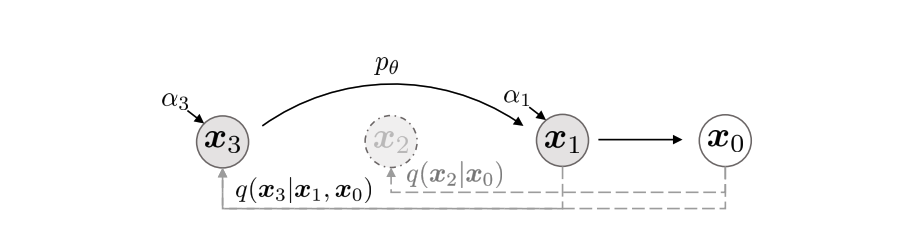

This approach allow ddpm's users skip some steps (with change of coefficients, not just delete step in ddpm chain). With this you can use fewer steps when $t$ ~ T, and more steps when $t$ ~ 0. Some works research different scheduling for $t$ moments to make ddpm steps, but standard case - is to use uniform shortened list of times - transit on K times between steps 

### DDIM dynamic

Single step in DDIM dynamic looks like: 

$x_{t_k} \sim q(x_{t-k}|x_t, x_0=x_0^{\theta})$

$x_{t-k} \sim \mathcal{N}(x_{t-k} | \sqrt{\bar{\alpha}_{t-k}}x_0^{\theta}(x_t, t) + \sqrt{1 - \bar{\alpha}_{t-k} - \sigma_t^2}\epsilon_{\theta}(x_t, t), \sigma_t^2 I)$

$x_{t-k} = \sqrt{\bar{\alpha}_{t-k}}x_0^{\theta}(x_t, t) + \sqrt{1 - \bar{\alpha}_{t-k} - \sigma_t^2}\epsilon_{\theta}(x_t, t) + \epsilon \sigma_t, \quad \sigma_t$ - coefficient for controlling determinism of chain

From $x_0^{\theta}$ you can get $\epsilon_{\theta}$ and vice versa

#### `DeterministicDynamic` (0.5 pts)
* In this module it's not expected to accelerate chain
* `mean_of_posterior_q` - mean of $q(x_{t-1}|x_t, x_0=x_0^{\theta})$
* `sample_from_posterior_q` - just simple mean of $q(x_{t-1}|x_t, x_0=x_0^{\theta})$

In [ ]:
class DeterministicDynamic(DDPMDynamic):
    def mean_of_posterior_q(
        self,
        x_t: Tensor,
        x_0: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        pass

    def sample_from_posterior_q(
        self,
        x_t: Tensor,
        x_0: Tensor,
        t: torch.LongTensor
    ):
        pass


In [ ]:
determ_sampler = Sampler(ddpm, DeterministicDynamic().to(device), parametrization='x_0')

grid = sample_images(determ_sampler, 100, device)

plt.imshow(grid)

## Accelerating ddpm chain via DDIM (1.5 pts)

* You can use already existing modules in help or create new one
* Implement DDIM with uniformly shortened list of times - make step in K moments in time at once, example: 9 -> 5 -> 1 -> 0

## Results (7 pts)
Demonstrate images generated from (3.4 pts):
* unconditional sampling with eps/x_0 parametrization (0.2 pts)
* conditional sampling with eps/x_0 parametrization with at least 3 not close temperatues (0.2 pts)
* deterministic unconditional sampling with eps/x_0 parametrization (0.2 pts)
* deterministic conditional sampling with eps/x_0 parametrization at least 3 not close temperatues (0.2 pts)

* accelerated unconditional sampling with eps/x_0 parametrization in 5, 10, 25, 50, 100, 200 times (1.2 pts)
* accelerated conditional sampling with eps/x_0 parametrization in 5, 10, 25, 50, 100, 200 times (1.2 pts)

You conclusion (3.6 pts):
* In what cases eps-parametrization is better than x_0 and vice-versa (indicate your generated images)
* How temperature influences on quality/divercity in your results (indicate)
* Why are you sure that your sampling in all cases is correct? How are you assure yourself in it's correctness? (explain your arguments how you debugged, arguments in style, - I got images correct, don't get scoring points)